In [88]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List
import seaborn as sns

In [59]:
DATA_DIR = Path.cwd().parent / "estimates"
FEATURES = ["Sex", "Age", "SibSp", "Parch", "Fare", "Pclass_1", "Pclass_2", "Pclass_3"]


def load_result(model: str, method: str) -> np.ndarray:
    arr = np.load(DATA_DIR / f"{model}_{method}.npy", allow_pickle=True)
    if len(arr.shape) == 1:
        arr = np.stack(arr)
    return arr


def load_df(model: str, method: str) -> pd.DataFrame:
    arr = load_result(model, method)
    df = pd.DataFrame(columns=FEATURES, data=arr)
    df["observation"] = df.index
    return df.melt(id_vars="observation", var_name="feature", value_name="shap_value")

In [60]:
for name in ["times_exact.npy", "times_kernel.npy", "times_uks.npy"]:
    print(np.load(Path.cwd().parent / name, allow_pickle=True))

[48.26709557 74.68177319  2.55753422]
[315.73649549 541.628793    99.40922451]
[[ 68.36794996  70.16046238  71.32849288  71.06542039 129.23967791]
 [ 82.03080273  81.57967925  79.76588106  80.50075841 161.99366498]
 [  9.83904243   9.76248479   9.4830935    9.70629406  14.85238791]]


In [61]:
MODELS = ["random_forest", "support_vector_machine", "logistic_regression"]
METHODS = ["10", "50", "100", "500", "1000", "kernel"]
GT_METHOD = "exact"

In [121]:
def create_comparison_df(model: str, method: str, gt_method: str) -> pd.DataFrame:
    gt_df = load_df(model, gt_method)
    df = load_df(model, method)
    df["model"] = model
    df["method"] = method if method == "kernel" else f"unbiased_{method}iter"
    res = df.merge(
        gt_df.rename(columns={"shap_value": "gt"}),
        how="inner",
        on=["observation", "feature"],
        validate="1:1",
    )
    res["error"] = abs(res.shap_value - res["gt"])
    return res


def compare_all_dfs(
    models: List[str], methods: List[str], gt_method: str
) -> pd.DataFrame:
    dfs = []
    for model in models:
        for method in methods:
            df = create_comparison_df(model, method, gt_method)
            dfs.append(df)
    return pd.concat(dfs)

In [135]:
create_comparison_df("random_forest", "10", GT_METHOD).head(1)

,observation,feature,shap_value,model,method,gt,error
0,0,Sex,-0.096338,random_forest,unbiased_10iter,-0.111698,0.01536


In [136]:
all_df = compare_all_dfs(MODELS, METHODS, GT_METHOD)
all_df.head(1)

,observation,feature,shap_value,model,method,gt,error
0,0,Sex,-0.096338,random_forest,unbiased_10iter,-0.111698,0.01536


In [137]:
agg_features_df = all_df.groupby(["observation", "model", "method"], as_index=False)[
    ["error", "gt"]
].sum()
agg_features_df["pct_error"] = agg_features_df["error"] / agg_features_df["gt"].abs()
# agg_features_df = agg_features_df.sort_values('diff')
agg_features_df.head(1)

,observation,model,method,error,gt,pct_error
0,0,logistic_regression,kernel,0.056686,-0.309716,0.183026


<AxesSubplot:xlabel='model', ylabel='error'>

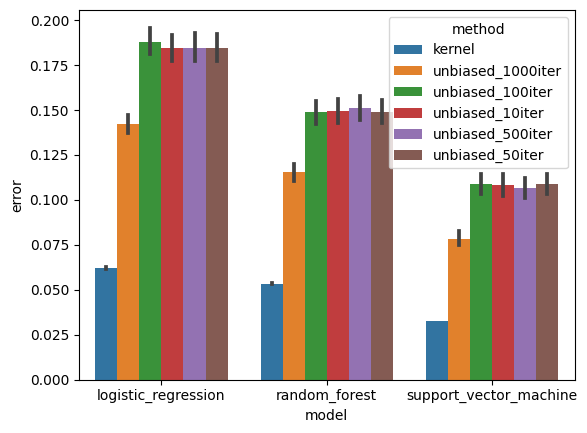

In [134]:
sns.barplot(data=agg_features_df, x="model", y="error", hue="method")

<AxesSubplot:xlabel='model', ylabel='pct_error'>

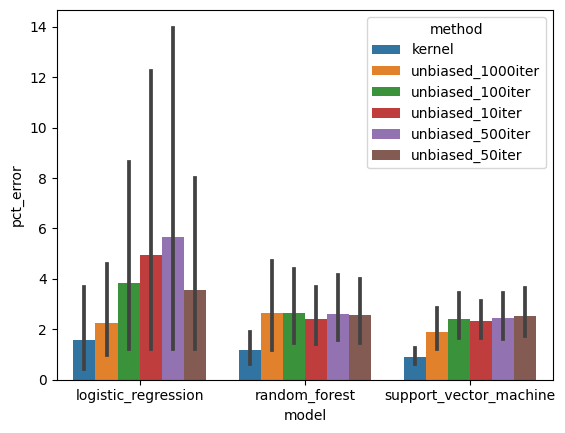

In [133]:
sns.barplot(data=agg_features_df, x="model", y="pct_error", hue="method")